# Time Series as Features

## Cycles
Cycles are patterns of growth and decay in a time series associated with how the value in a series at one time depends on values at previous times, but not necessarily on the time step itself.

Cyclic behavior vs Seasonality

* **Cyclic Behavior**:
  1. Cyclic behavior refers to repetitive patterns or fluctuations in data that occur over longer time intervals than seasonality.
  2. Cycles are often irregular in duration and amplitude, and they do not have fixed or predictable periods.
  3. Cycles typically result from economic, business, or environmental factors that operate over longer time horizons, such as business cycles, economic expansions and contractions, or long-term climate cycles.
  4. Unlike seasonality, cyclic behavior does not follow fixed calendar-based patterns and may not exhibit consistent periodicity over time.
* **Seasonality**:
  1. Seasonality refers to regular, predictable patterns or fluctuations in data that occur at fixed intervals or periods.
  2. Seasonal patterns repeat with a consistent frequency or period, such as daily, weekly, monthly, or yearly.
  3. Seasonality is often influenced by calendar effects, weather patterns, holidays, or other recurring events that occur on a regular basis.
  4. Seasonal patterns are typically more uniform and consistent compared to cyclic behavior, with clear peaks and troughs occurring at specific times of the year or other intervals.
  4. Seasonality can be decomposed into distinct seasonal components, such as daily, weekly, or monthly effects, which can be modeled and analyzed separately.

## Lagged Series and Lag Plots

To investigate possible serial dependence (like cycles) in a time series, we need to create "lagged" copies of the series.

In [1]:
import pandas as pd

# Federal Reserve dataset: https://www.kaggle.com/federalreserve/interest-rates
reserve = pd.read_csv(
    "data/reserve.csv",
    parse_dates={'Date': ['Year', 'Month', 'Day']},
    index_col='Date',
)

y = reserve.loc[:, 'Unemployment Rate']\
           .dropna()\
           .to_period('M') # Convert DataFrame from DatetimeIndex to PeriodIndex.

df = pd.DataFrame({
    'y': y,
    'y_lag_1': y.shift(1),
    'y_lag_2': y.shift(2),    
})

df.head()

/var/folders/1h/vlrnbgl95c9977yrrq362r880000gn/T/ipykernel_31540/2188995999.py:4: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  reserve = pd.read_csv(


,y,y_lag_1,y_lag_2
Date,,,
1954-07,5.8,NaN,NaN
1954-08,6.0,5.8,NaN
1954-09,6.1,6.0,5.8
1954-10,5.7,6.1,6.0
1954-11,5.3,5.7,6.1


By lagging a time series, we can make its past values appear contemporaneous with the values we are trying to predict (in the same row, in other words). This makes lagged series useful as features for modeling serial dependence. To forecast the US unemployment rate series, we could use y_lag_1 and y_lag_2 as features to predict the target y. This would forecast the future unemployment rate as a function of the unemployment rate in the prior two months.

## Choosing lags
It generally won't be useful to include every lag with a large autocorrelation.

**Partial autocorrelation** tells you the correlation of a lag accounting for all of the previous lags -- the amount of "new" correlation the lag contributes.

Plotting the partial autocorrelation can help you choose which lag features to use. In the figure below, lag 1 through lag 6 fall outside the intervals of "no correlation" (in blue), so we might choose lags 1 through lag 6 as features for US Unemployment. (Lag 11 is likely a false positive.)

Below is a correlogram which plots the partial autocorrelation. In the figure , lag 1 through lag 6 fall outside the intervals of "no correlation" (in blue), so we might choose lags 1 through lag 6 as features. (Lag 11 is likely a false positive.)
![correlogram](image/correlogram.png)

> **Autocorrelation** and **partial autocorrelation** are measures of linear dependence. In real-world time series often have substantial non-linear dependences, it's best to look at a lag plot (or use some more general measure of dependence, like [mutual information](https://www.kaggle.com/code/ryanholbrook/mutual-information/tutorial)) when choosing lag features. The Sunspots series has lags with non-linear dependence which we might overlook with autocorrelation.

![lag_plot_sunspots](image/lag_plot_sunspots.png)

<em>Lag plot of the Sunspots series</em>

# Example - Flu Trends

The Flu Trends dataset contains records of doctor's visits for the flu for weeks between 2009 and 2016. Our goal is to forecast the number of flu cases for the coming weeks.

We will take two approaches:
1. using lag feature
2. using lags of another set of time series: flu-related search terms as captured by Google Trends

### Load and plot data

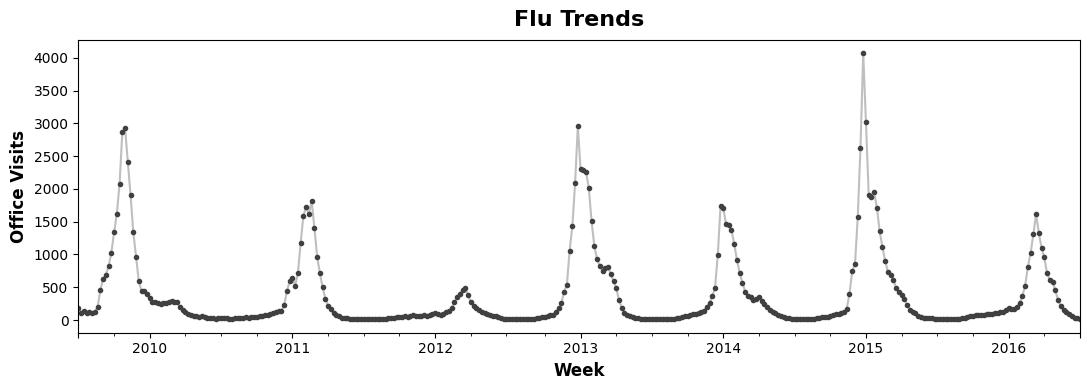

In [2]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf

simplefilter("ignore")

# Set Matplotlib defaults
# plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
# %config InlineBackend.figure_format = 'retina'


def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig


flu_trends = pd.read_csv("data/flu-trends.csv")
flu_trends.set_index(
    pd.PeriodIndex(flu_trends.Week, freq="W"),
    inplace=True,
)
flu_trends.drop("Week", axis=1, inplace=True)

ax = flu_trends.FluVisits.plot(title='Flu Trends', **plot_params)
_ = ax.set(ylabel="Office Visits")

Our Flu Trends data shows irregular cycles instead of a regular seasonality.



### Lag plots
Let's take a look at the lag and autocorrelation plots first:

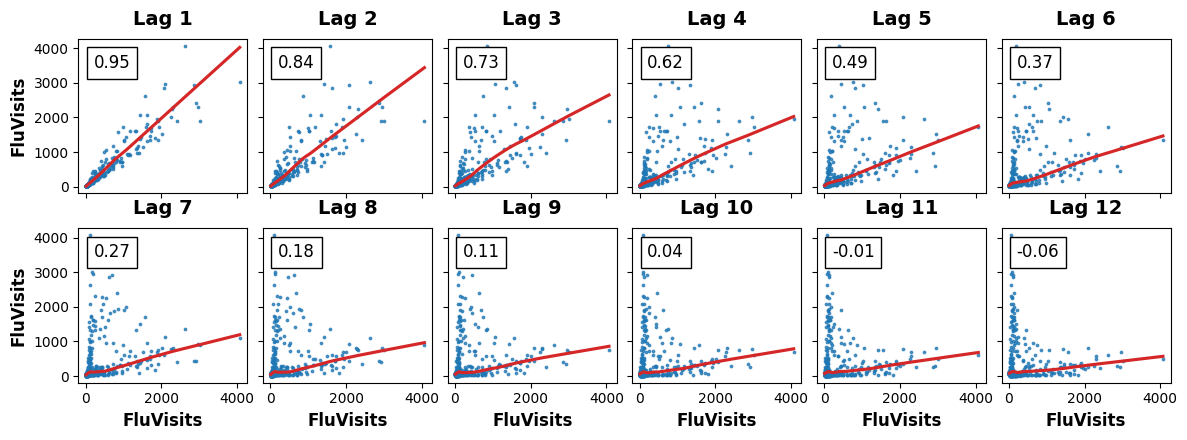

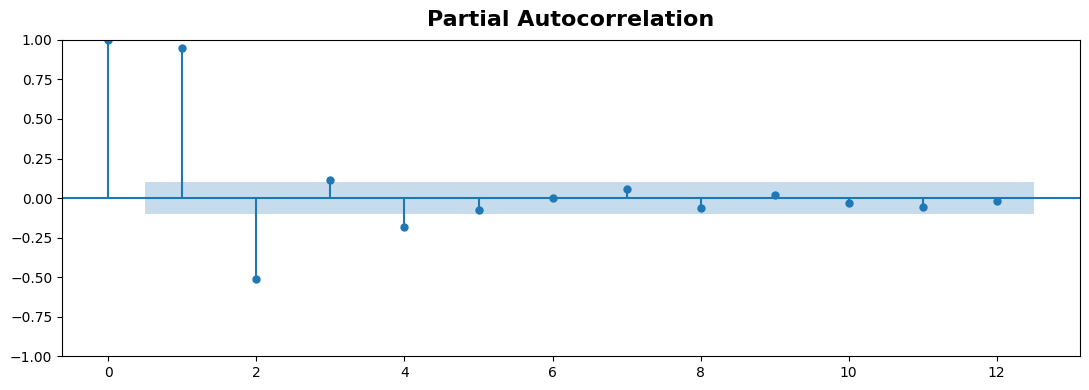

In [3]:
_ = plot_lags(flu_trends.FluVisits, lags=12, nrows=2)
_ = plot_pacf(flu_trends.FluVisits, lags=12)

Analyze plots:
* Lag plots indicates the relationship of FluVisits to its lags is mostly linear
* Partial autocorrelations suggests the dependence can be captured using lags 1, 2, 3, and 4

In [4]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


X = make_lags(flu_trends.FluVisits, lags=4)
X = X.fillna(0.0)

In [5]:
X.head()

,y_lag_1,y_lag_2,y_lag_3,y_lag_4
Week,,,,
2009-06-29/2009-07-05,0.0,0.0,0.0,0.0
2009-07-06/2009-07-12,180.0,0.0,0.0,0.0
2009-07-13/2009-07-19,115.0,180.0,0.0,0.0
2009-07-20/2009-07-26,132.0,115.0,180.0,0.0
2009-07-27/2009-08-02,109.0,132.0,115.0,180.0


### Forecast
When using lag features, we are limited to forecasting time steps whose lagged values are available. Using a lag 1 feature on Monday, we can't make a forecast for Wednesday because the lag 1 value needed is Tuesday which hasn't happened yet

In [6]:
# Create target series and data splits
y = flu_trends.FluVisits.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

### Plot predicts and forecasts

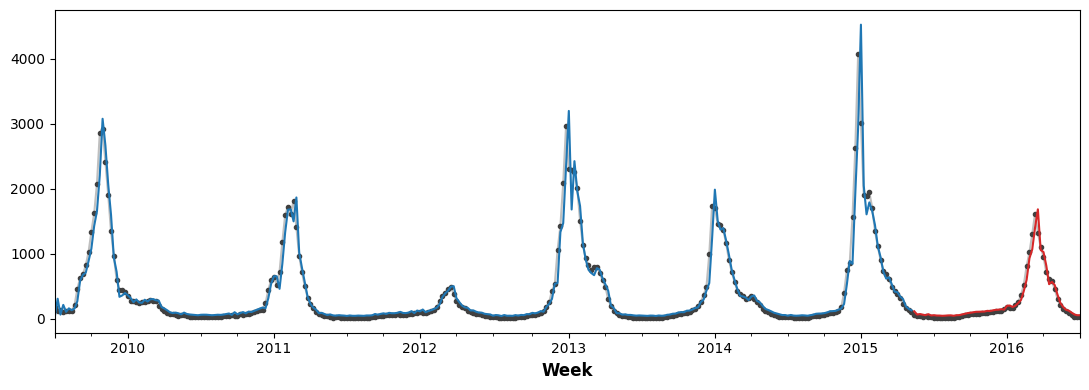

In [7]:
ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')

See diagram below, the model using lags only forecast performance is worse on sudden changes.

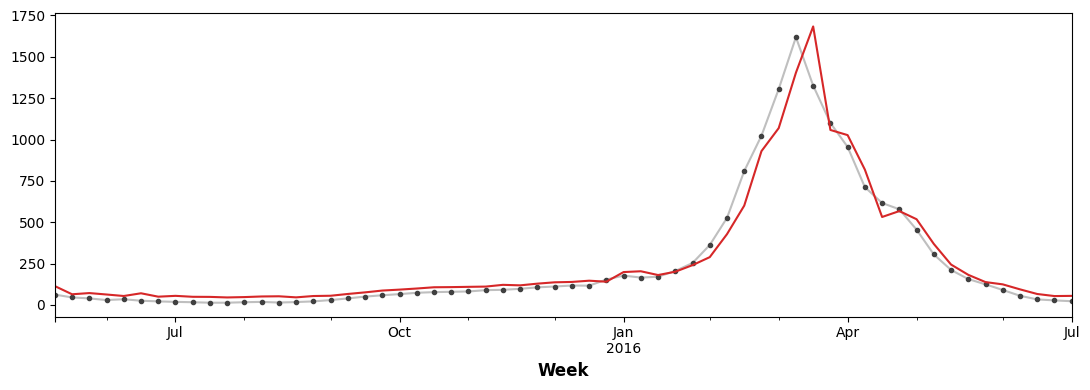

In [8]:
ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

Let's see how our model needs a time step to react to sudden changes.

To improve the forecast, we could try to find **`leading indicators`** that could provide an "early warning" for sudden changes. 

Plotting the search phrase `'FluCough'` against the target `'FluVisits'` suggests such search terms could be useful as leading indicators: flu-related searches tend to become more popular in the weeks prior to office visits.

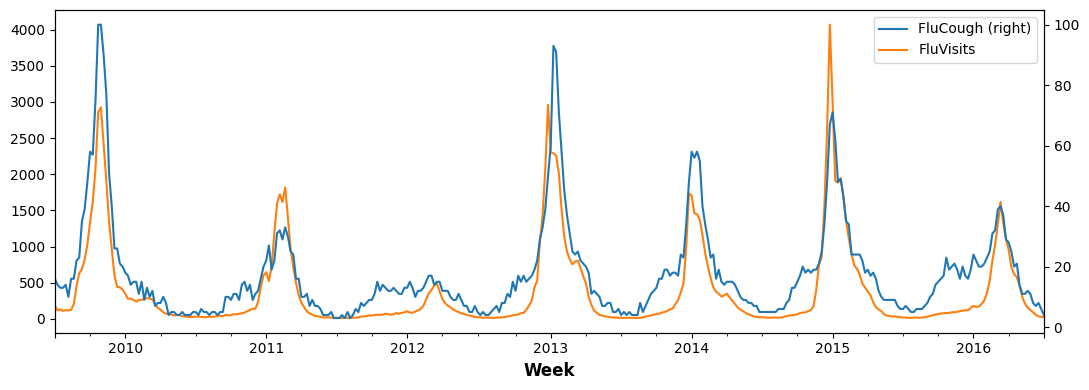

In [9]:
ax = flu_trends.plot(
    y=["FluCough", "FluVisits"],
    secondary_y="FluCough",
)

The dataset contains 129 such terms, but we'll just use a few.

In [10]:
search_terms = ["FluContagious", "FluCough", "FluFever", "InfluenzaA", "TreatFlu", "IHaveTheFlu", "OverTheCounterFlu", "HowLongFlu"]

# Create three lags for each search term
X0 = make_lags(flu_trends[search_terms], lags=3)
X0.columns = [' '.join(col).strip() for col in X0.columns.values]

# Create four lags for the target, as before
X1 = make_lags(flu_trends['FluVisits'], lags=4)

# Combine to create the training data
X = pd.concat([X0, X1], axis=1).fillna(0.0)

In [11]:
print("X0")
display(X0.head())

print("X1")
display(X1.head())

X0


,y_lag_1 FluContagious,y_lag_1 FluCough,y_lag_1 FluFever,y_lag_1 InfluenzaA,y_lag_1 TreatFlu,y_lag_1 IHaveTheFlu,y_lag_1 OverTheCounterFlu,y_lag_1 HowLongFlu,y_lag_2 FluContagious,y_lag_2 FluCough,...,y_lag_2 OverTheCounterFlu,y_lag_2 HowLongFlu,y_lag_3 FluContagious,y_lag_3 FluCough,y_lag_3 FluFever,y_lag_3 InfluenzaA,y_lag_3 TreatFlu,y_lag_3 IHaveTheFlu,y_lag_3 OverTheCounterFlu,y_lag_3 HowLongFlu
Week,,,,,,,,,,,,,,,,,,,,,
2009-06-29/2009-07-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-06/2009-07-12,5.0,16.0,15.0,36.0,6.0,5.0,11.0,6.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-13/2009-07-19,6.0,14.0,15.0,25.0,12.0,7.0,7.0,7.0,5.0,16.0,...,11.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-20/2009-07-26,6.0,13.0,13.0,24.0,8.0,8.0,7.0,7.0,6.0,14.0,...,7.0,7.0,5.0,16.0,15.0,36.0,6.0,5.0,11.0,6.0
2009-07-27/2009-08-02,5.0,13.0,12.0,23.0,5.0,4.0,6.0,6.0,6.0,13.0,...,7.0,7.0,6.0,14.0,15.0,25.0,12.0,7.0,7.0,7.0


X1


,y_lag_1,y_lag_2,y_lag_3,y_lag_4
Week,,,,
2009-06-29/2009-07-05,NaN,NaN,NaN,NaN
2009-07-06/2009-07-12,180.0,NaN,NaN,NaN
2009-07-13/2009-07-19,115.0,180.0,NaN,NaN
2009-07-20/2009-07-26,132.0,115.0,180.0,NaN
2009-07-27/2009-08-02,109.0,132.0,115.0,180.0


### Train and plot the new model

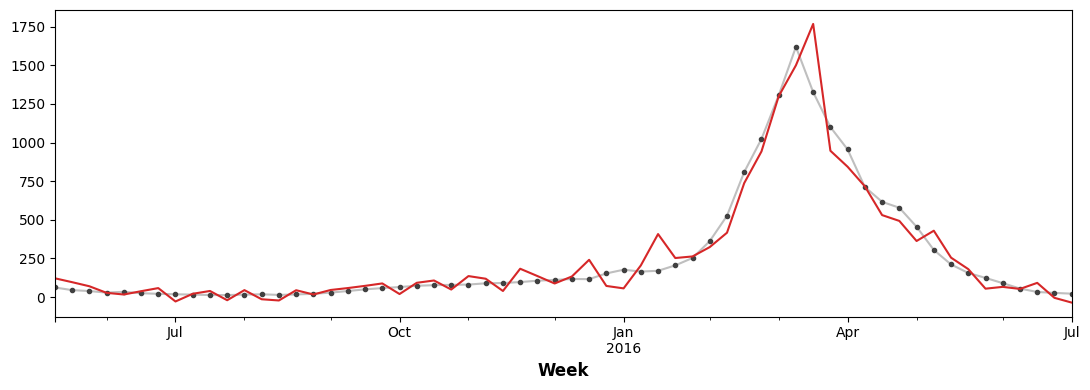

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

Our model appears to be better able to anticipate sudden increases in flu visits, suggesting that the several time series of search popularity were indeed effective as leading indicators.